# Jigsaw - Agile Community Rules Classification
### https://www.kaggle.com/competitions/jigsaw-agile-community-rules

## Constrained Generation for Reddit Content Moderation: Binary Classification Using Logit Probabilities
Technical Overview
This notebook implements a constrained generation approach for automated content moderation using a Llama 3.2-1B model. Instead of relying on traditional text parsing, we employ logits processors to restrict the model's output vocabulary to only "True" and "False" tokens, then extract probabilistic confidence scores directly from the model's logit distributions.
A reference notebook from  https://www.kaggle.com/code/xbar19/jigsaw-llama3-1-8b-instruct-fine-tuned is appreciated.

## Install packages on Kaggle: Add-ons > Install Dependencies 

```bash
pip install pip3-autoremove
pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu124
pip install unsloth vllm
pip install scikit-learn
```

In [1]:
import kagglehub
import pandas as pd
import os
import glob
import pandas as pd

# Your path and files
base_path = "./data/final/"
files = ["df_test_cr_12.csv"]  # Put your file names here

# Load and combine
dfs = [pd.read_csv(f"{base_path}{file}") for file in files]
df_test = pd.concat(dfs, ignore_index=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)
#df_test['violates_rule_yn'] = df_test['violates_rule'].map({True: "Yes", False: "No"})
print(f"Combined shape: {df_test.shape}")

df_test.head(10)

#df_test=df_test[:100]

Combined shape: (2000, 8)


,subreddit,rule,positive_example_1,negative_example_1,positive_example_2,negative_example_2,test_comment,violates_rule
0,EnoughTrumpSpam,No legal advice: Do not offer or request legal...,"""IANAL but you should definitely file a lawsui...","""This political situation is absolutely insane...","""Can someone tell me what specific criminal ch...","""I can't believe the sheer volume of terrible ...","""Someone please explain the exact legal steps ...",Yes
1,technology,No legal advice: Do not offer or request legal...,My ISP just throttled my connection after I do...,Has anyone else noticed their internet speeds ...,"If your employer monitors your personal phone,...",That new privacy policy update seems sketchy a...,My neighbor's wifi is interfering with my home...,Yes
2,changemyview,no medical advice: do not offer or request spe...,You should definitely try taking 500mg of ibup...,"I've been struggling with sleep issues too, bu...","OP, based on your symptoms it sounds like you ...",Have you considered talking to a mental health...,I'm not a doctor so I can't give medical advic...,No
3,askscience,"No Advertising: Spam, referral links, unsolici...","For anyone struggling with this concept, I hig...",This paper from the 2018 Nature Physics issue ...,My startup actually developed an app that expl...,You're confusing correlation with causation he...,As someone who's tried every supplement out th...,Yes
4,NeutralPolitics,no financial advice: we do not permit comments...,Honestly if you're looking to build wealth qui...,The Congressional Budget Office report suggest...,"For anyone struggling with taxes, I highly rec...","According to Federal Reserve data, the current...","If you want to advance your career quickly, yo...",Yes
5,sex,no medical advice: do not offer or request spe...,"""Hey guys I've had this weird discharge for 3 ...","""That sounds really uncomfortable. You should ...","""OP you definitely have herpes based on that d...","""I had something similar happen last year. End...","""Has anyone else experienced burning after sex...",No
6,worldnews,No legal advice: Do not offer or request legal...,You should immediately file a lawsuit against ...,The way some countries handle protestors is ab...,"If your employer is violating labor laws, gath...",This is exactly why we need stronger internati...,Contact an immigration lawyer immediately and ...,Yes
7,legaladvice,No legal advice: Do not offer or request legal...,"""IANAL but you should definitely file a motion...","""This sounds like a complicated situation that...","""OP you need to contact an employment lawyer R...","""I'm not a lawyer, but generally speaking, lan...","""This is way above Reddit's paygrade. You shou...",No
8,gifs,no spoilers: do not reveal important details t...,Just wait until the final scene when the main ...,This reminds me of that one movie where things...,The twist where the wife was the killer the wh...,"Man, I need to watch whatever this is from! Th...",That cinematography is absolutely stunning! Ma...,No
9,CanadaPolitics,no promotion of illegal activity: do not encou...,Honestly just buy weed from your local dealer ...,The government's approach to harm reduction se...,"If they try to enforce that mandate, people sh...",This legislation would essentially criminalize...,Honestly if someone breaks into your car just ...,Yes


## Load LLM (llama-3.2-1B) model with vLLM (Suitable for batch inference) (logits output)

In [2]:
import multiprocessing as mp
mp.set_start_method('spawn', force=True)
import os
os.environ['VLLM_USE_V1'] = '0'  # Force V0 for logits processor support

import torch
import numpy as np
import pandas as pd
from vllm import LLM, SamplingParams
from transformers import LogitsProcessor
import math
from vllm.lora.request import LoRARequest


class YesNoLogitsProcessor(LogitsProcessor):
    """Forces model to only output Yes or No tokens"""
    def __init__(self, allowed_ids):
        self.allowed_ids = allowed_ids
        
    def __call__(self, input_ids, scores: torch.Tensor) -> torch.Tensor:
        # Create a mask that's -inf for all tokens except allowed ones
        mask = torch.full_like(scores, float('-inf'))
        mask[self.allowed_ids] = 0
        
        # Apply the mask to force only allowed tokens
        scores = scores + mask
        return scores



class LlamaClassifier:
    def __init__(self):
        # Model path selection
        if os.getenv('KAGGLE_KERNEL_RUN_TYPE'):
            self.model_path = "/kaggle/input/qwen2.5/transformers/14b-instruct-gptq-int4/1"
        else:
            #self.model_path = "unsloth/Qwen2.5-0.5B-Instruct"
            self.model_path = "./lora/Qwen25_05B_Instruct_unsloth_lora_fp16_r64_a64_s105759_e_1_msl3072-0-swap-cr123-kdsr1-gksr1_merged_fp16"
        # Initialize model with LoRA support
        self.model = LLM(
            model=self.model_path,
            #quantization='gptq',
            #quantization="bitsandbytes",
            max_model_len=3072,
            tensor_parallel_size=1,
            gpu_memory_utilization=0.5,
            seed=123,
            trust_remote_code=True,
            dtype="half",
            enforce_eager=True,
            disable_log_stats=True,
            enable_prefix_caching=True,
            enable_lora=False,
            max_lora_rank=64
        )
        
        
        self.tokenizer = self.model.get_tokenizer()
        self.setup_token_constraints()
        
        # Sampling with constrained output - try more balanced parameters
        logits_processors = [YesNoLogitsProcessor(self.KEEP)]
        self.sampling_params = SamplingParams(
            n=1,
            temperature=0.0,  # Lower temperature for more deterministic
            seed=777,
            skip_special_tokens=True,
            max_tokens=1,
            logits_processors=logits_processors,
            logprobs=2
        )
    
    def setup_token_constraints(self):
        """Get token IDs for 'No' and 'Yes'"""
        choices = ["No", "Yes"]
        self.KEEP = []
        for x in choices:
            c = self.tokenizer.encode(x, add_special_tokens=False)[0]
            self.KEEP.append(c)
        
        self.no_token_id = self.KEEP[0]
        self.yes_token_id = self.KEEP[1]
        print(f"Constrained to tokens: {self.KEEP} = {choices}")
        print(f"No token: {self.no_token_id}, Yes token: {self.yes_token_id}")

    def create_lora_request(self, lora_adapter_path, adapter_name="custom_adapter"):
        """Create LoRA request object"""
        return LoRARequest(
            lora_name=adapter_name,
            lora_int_id=1,
            lora_local_path=lora_adapter_path
        )
    
    def create_prompt(self, input_data: pd.Series):
        # Create system message - EXACT match to training
        system_msg = f"""You are a really experienced moderator for the subreddit /r/{input_data['subreddit']}. 
    Your job is to determine if the following reported comment violates the given rule. Answer with only Yes or No."""
        
        # User message - EXACT XML structure as training (no extra newlines)
        user_msg = f"""<rule>
    {input_data['rule']}
    </rule>
    <examples>
    <example>
    <comment>{input_data['positive_example_1']}</comment>
    <rule_violation>Yes</rule_violation>
    </example>
    <example>
    <comment>{input_data['positive_example_2']}</comment>
    <rule_violation>Yes</rule_violation>
    </example>
    <example>
    <comment>{input_data['negative_example_1']}</comment>
    <rule_violation>No</rule_violation>
    </example>
    <example>
    <comment>{input_data['negative_example_2']}</comment>
    <rule_violation>No</rule_violation>
    </example>
    </examples>
    <test_comment>
    {input_data['test_comment']}
    </test_comment>"""
        
        messages = [
            {"role": "system", "content": system_msg},
            {"role": "user", "content": user_msg}
        ]
        
        formatted_prompt = self.tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        
        return formatted_prompt
    
    def predict_classification(self, input_data: pd.Series, lora_adapter_path=None):
        """Single prediction with optional LoRA"""
        prompt = self.create_prompt(input_data)
        
        # Add LoRA request if path provided
        generate_kwargs = {"use_tqdm": False}
        if lora_adapter_path:
            generate_kwargs["lora_request"] = self.create_lora_request(lora_adapter_path)
        
        responses = self.model.generate([prompt], self.sampling_params, **generate_kwargs)
        
        response = responses[0]
        print("Debug response:", response)
        
        predicted_text = response.outputs[0].text.strip()
        
        try:
            x = response.outputs[0].logprobs[0]
            print("Debug logprobs:", x)
            
            # Extract probabilities for No/Yes tokens
            logprobs = []
            for k in self.KEEP:
                if k in x:
                    logprobs.append(math.exp(x[k].logprob))
                else:
                    logprobs.append(0)
            
            logprobs = np.array(logprobs)
            logprobs /= (logprobs.sum() + 1e-15)
            
            print(f"Debug: Raw logprobs: {logprobs}, No prob: {logprobs[0]}, Yes prob: {logprobs[1]}")
            
            violation_probability = logprobs[1]  # Yes probability
            confidence = max(logprobs)
            
        except Exception as e:
            print(f"Error: {e}")
            violation_probability = 0.5
            confidence = 0.5
        
        return {
            'prediction': predicted_text,
            'is_violation': violation_probability > 0.5,
            'violation_probability': violation_probability,
            'confidence': confidence
        }
    
    def predict_batch(self, input_data_list, verbose=False, lora_adapter_path=None):
        """Batch predictions with optional LoRA"""
        prompts = [self.create_prompt(data) for data in input_data_list]
        
        # Add LoRA request if path provided
        generate_kwargs = {"use_tqdm": True}
        if lora_adapter_path:
            generate_kwargs["lora_request"] = self.create_lora_request(lora_adapter_path)
        
        responses = self.model.generate(prompts, self.sampling_params, **generate_kwargs)
        
        results = []
        for i, response in enumerate(responses):
            try:
                predicted_text = response.outputs[0].text.strip()
                x = response.outputs[0].logprobs[0]
                
                # Extract probabilities
                logprobs = []
                for k in self.KEEP:
                    if k in x:
                        logprobs.append(math.exp(x[k].logprob))
                    else:
                        logprobs.append(0)
                
                logprobs = np.array(logprobs)
                logprobs /= (logprobs.sum() + 1e-15)
                
                violation_probability = logprobs[1]  # Yes probability
                confidence = max(logprobs)
                
            except Exception as e:
                print(f"Error {i}: {e}")
                violation_probability = 0.5
                confidence = 0.5
                predicted_text = "Error"
            
            result = {
                'prediction': predicted_text,
                'is_violation': violation_probability > 0.5,
                'violation_probability': violation_probability,
                'confidence': confidence,
                'sample_index': i
            }
            
            results.append(result)
        
        return results

    # Convenience methods for LoRA usage
    def predict_with_lora(self, input_data: pd.Series, lora_adapter_path):
        """Single prediction using LoRA adapter"""
        return self.predict_classification(input_data, lora_adapter_path)
    
    def predict_batch_with_lora(self, input_data_list, lora_adapter_path, verbose=False):
        """Batch predictions using LoRA adapter"""
        return self.predict_batch(input_data_list, verbose, lora_adapter_path)

INFO 10-19 19:56:25 [__init__.py:235] Automatically detected platform cuda.


## Instantiate the model=vLLM

In [3]:
model=LlamaClassifier()

WARNING 10-19 19:56:32 [config.py:3443] Casting torch.bfloat16 to torch.float16.
INFO 10-19 19:56:32 [config.py:1604] Using max model len 3072
WARNING 10-19 19:56:32 [cuda.py:103] To see benefits of async output processing, enable CUDA graph. Since, enforce-eager is enabled, async output processor cannot be used
INFO 10-19 19:56:32 [llm_engine.py:228] Initializing a V0 LLM engine (v0.10.0) with config: model='./lora/Qwen25_05B_Instruct_unsloth_lora_fp16_r64_a64_s105759_e_1_msl3072-0-swap-cr123-kdsr1-gksr1_merged_fp16', speculative_config=None, tokenizer='./lora/Qwen25_05B_Instruct_unsloth_lora_fp16_r64_a64_s105759_e_1_msl3072-0-swap-cr123-kdsr1-gksr1_merged_fp16', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_seq_len=3072, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None,

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 10-19 19:56:34 [default_loader.py:262] Loading weights took 0.50 seconds
INFO 10-19 19:56:35 [model_runner.py:1115] Model loading took 0.9277 GiB and 0.595195 seconds
INFO 10-19 19:56:35 [worker.py:295] Memory profiling takes 0.45 seconds
INFO 10-19 19:56:35 [worker.py:295] the current vLLM instance can use total_gpu_memory (15.69GiB) x gpu_memory_utilization (0.50) = 7.85GiB
INFO 10-19 19:56:35 [worker.py:295] model weights take 0.93GiB; non_torch_memory takes 0.08GiB; PyTorch activation peak memory takes 1.39GiB; the rest of the memory reserved for KV Cache is 5.45GiB.
INFO 10-19 19:56:35 [executor_base.py:113] # cuda blocks: 29756, # CPU blocks: 21845
INFO 10-19 19:56:35 [executor_base.py:118] Maximum concurrency for 3072 tokens per request: 154.98x
INFO 10-19 19:56:37 [llm_engine.py:424] init engine (profile, create kv cache, warmup model) took 2.91 seconds
Constrained to tokens: [2753, 9454] = ['No', 'Yes']
No token: 2753, Yes token: 9454


## Prediction for test-dataset-LoRA (batch)

In [4]:
# from tqdm import tqdm
# import numpy as np
# print(df_test.shape)
# lora_path="./lora/Qwen25_3B_Instruct_unsloth_lora_fp16_r64_a64_s15148_e_2_msl2048-0-cr12-qcr12345"
# def process_dataframe_in_batches(model, df, batch_size=12):
#     """Process dataframe using batch predictions with progress bar"""
    
#     # Calculate number of batches
#     num_batches = len(df) // batch_size + (1 if len(df) % batch_size > 0 else 0)
    
#     all_results = []
    
#     # Process in batches with progress bar
#     with tqdm(total=len(df), desc="Processing predictions") as pbar:
#         for i in range(0, len(df), batch_size):
#             # Get current batch
#             batch_df = df.iloc[i:i+batch_size]
            
#             # Convert batch to list of Series (input format for predict_batch)
#             batch_list = [row for _, row in batch_df.iterrows()]  # Fixed: removed asterisks and fixed variable name
            
#             # Get predictions for this batch
#             batch_results = model.predict_batch_with_lora(batch_list,lora_path)
            
#             # Add to results
#             all_results.extend(batch_results)
            
#             # Update progress bar
#             pbar.update(len(batch_df))
#             pbar.set_postfix({'Batch': f'{i//batch_size + 1}/{num_batches}'})
    
#     return all_results

# # Process in batches
# predictions = process_dataframe_in_batches(model, df_test, batch_size=12)
# df_test['prediction'] = [pred['prediction'] for pred in predictions] 

## Prediction without-LoRA (batch)

In [5]:
from tqdm import tqdm
import numpy as np
print(df_test.shape)
def process_dataframe_in_batches(model, df, batch_size=12):
    """Process dataframe using batch predictions with progress bar"""
    
    # Calculate number of batches
    num_batches = len(df) // batch_size + (1 if len(df) % batch_size > 0 else 0)
    
    all_results = []
    
    # Process in batches with progress bar
    with tqdm(total=len(df), desc="Processing predictions") as pbar:
        for i in range(0, len(df), batch_size):
            # Get current batch
            batch_df = df.iloc[i:i+batch_size]
            
            # Convert batch to list of Series (input format for predict_batch)
            batch_list = [row for _, row in batch_df.iterrows()]  # Fixed: removed asterisks and fixed variable name
            
            # Get predictions for this batch
            batch_results = model.predict_batch(batch_list)
            
            # Add to results
            all_results.extend(batch_results)
            
            # Update progress bar
            pbar.update(len(batch_df))
            pbar.set_postfix({'Batch': f'{i//batch_size + 1}/{num_batches}'})
    
    return all_results

# Process in batches
predictions = process_dataframe_in_batches(model, df_test, batch_size=24)

# Add predictions to dataframe - extract violation probabilities from the list of dictionaries
df_test['prediction'] = [pred['prediction'] for pred in predictions]  # Fixed: extract from list and fixed typo

(2000, 8)


Processing predictions:   0%|                          | 0/2000 [00:00<?, ?it/s]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   1%|    | 24/2000 [00:00<00:17, 110.93it/s, Batch=1/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   2%|    | 48/2000 [00:00<00:14, 131.21it/s, Batch=2/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   4%|▏   | 72/2000 [00:00<00:13, 141.38it/s, Batch=3/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   5%|▏   | 96/2000 [00:00<00:13, 143.77it/s, Batch=4/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   6%|▏  | 120/2000 [00:00<00:12, 149.77it/s, Batch=5/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   7%|▏  | 144/2000 [00:01<00:12, 150.18it/s, Batch=6/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   8%|▎  | 168/2000 [00:01<00:11, 156.09it/s, Batch=7/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  10%|▎  | 192/2000 [00:01<00:11, 158.94it/s, Batch=8/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  11%|▎  | 216/2000 [00:01<00:11, 160.19it/s, Batch=9/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  12%|▏ | 240/2000 [00:01<00:10, 163.14it/s, Batch=10/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  13%|▎ | 264/2000 [00:01<00:10, 164.36it/s, Batch=11/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  14%|▎ | 288/2000 [00:01<00:10, 166.32it/s, Batch=12/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  16%|▎ | 312/2000 [00:02<00:10, 166.63it/s, Batch=13/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  17%|▎ | 336/2000 [00:02<00:10, 165.96it/s, Batch=14/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  18%|▎ | 360/2000 [00:02<00:09, 166.14it/s, Batch=15/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  19%|▍ | 384/2000 [00:02<00:09, 167.52it/s, Batch=16/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  20%|▍ | 408/2000 [00:02<00:09, 166.20it/s, Batch=17/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  22%|▍ | 432/2000 [00:02<00:09, 166.75it/s, Batch=18/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  23%|▍ | 456/2000 [00:02<00:09, 170.38it/s, Batch=19/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  24%|▍ | 480/2000 [00:02<00:08, 172.09it/s, Batch=20/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  25%|▌ | 504/2000 [00:03<00:08, 171.64it/s, Batch=21/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  26%|▌ | 528/2000 [00:03<00:08, 172.57it/s, Batch=22/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  28%|▌ | 552/2000 [00:03<00:08, 173.35it/s, Batch=23/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  29%|▌ | 576/2000 [00:03<00:08, 174.03it/s, Batch=24/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  30%|▌ | 600/2000 [00:03<00:07, 175.01it/s, Batch=25/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  31%|▌ | 624/2000 [00:03<00:07, 175.91it/s, Batch=26/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  32%|▋ | 648/2000 [00:03<00:07, 176.46it/s, Batch=27/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  34%|▋ | 672/2000 [00:04<00:07, 175.50it/s, Batch=28/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  35%|▋ | 696/2000 [00:04<00:07, 175.27it/s, Batch=29/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  36%|▋ | 720/2000 [00:04<00:07, 177.03it/s, Batch=30/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  37%|▋ | 744/2000 [00:04<00:07, 177.57it/s, Batch=31/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  38%|▊ | 768/2000 [00:04<00:06, 177.67it/s, Batch=32/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  40%|▊ | 792/2000 [00:04<00:06, 178.14it/s, Batch=33/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  41%|▊ | 816/2000 [00:04<00:06, 177.31it/s, Batch=34/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  42%|▊ | 840/2000 [00:05<00:06, 178.28it/s, Batch=35/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  43%|▊ | 864/2000 [00:05<00:06, 177.30it/s, Batch=36/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  44%|▉ | 888/2000 [00:05<00:06, 178.46it/s, Batch=37/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  46%|▉ | 912/2000 [00:05<00:06, 179.23it/s, Batch=38/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  47%|▉ | 936/2000 [00:05<00:05, 179.38it/s, Batch=39/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  48%|▉ | 960/2000 [00:05<00:05, 179.46it/s, Batch=40/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  49%|▉ | 984/2000 [00:05<00:05, 179.47it/s, Batch=41/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  50%|▌| 1008/2000 [00:05<00:05, 179.72it/s, Batch=42/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  52%|▌| 1032/2000 [00:06<00:05, 179.55it/s, Batch=43/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  53%|▌| 1056/2000 [00:06<00:05, 179.41it/s, Batch=44/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  54%|▌| 1080/2000 [00:06<00:05, 181.27it/s, Batch=45/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  55%|▌| 1104/2000 [00:06<00:04, 181.51it/s, Batch=46/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  56%|▌| 1128/2000 [00:06<00:04, 181.55it/s, Batch=47/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  58%|▌| 1152/2000 [00:06<00:04, 179.85it/s, Batch=48/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  59%|▌| 1176/2000 [00:06<00:04, 180.90it/s, Batch=49/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  60%|▌| 1200/2000 [00:07<00:04, 181.54it/s, Batch=50/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  61%|▌| 1224/2000 [00:07<00:04, 181.42it/s, Batch=51/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  62%|▌| 1248/2000 [00:07<00:04, 180.19it/s, Batch=52/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  64%|▋| 1272/2000 [00:07<00:04, 181.08it/s, Batch=53/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  65%|▋| 1296/2000 [00:07<00:03, 180.48it/s, Batch=54/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  66%|▋| 1320/2000 [00:07<00:03, 179.58it/s, Batch=55/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  67%|▋| 1344/2000 [00:07<00:03, 181.69it/s, Batch=56/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  68%|▋| 1368/2000 [00:07<00:03, 183.59it/s, Batch=57/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  70%|▋| 1392/2000 [00:08<00:03, 181.74it/s, Batch=58/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  71%|▋| 1416/2000 [00:08<00:03, 181.77it/s, Batch=59/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  72%|▋| 1440/2000 [00:08<00:03, 182.45it/s, Batch=60/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  73%|▋| 1464/2000 [00:08<00:02, 182.42it/s, Batch=61/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  74%|▋| 1488/2000 [00:08<00:02, 183.15it/s, Batch=62/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  76%|▊| 1512/2000 [00:08<00:02, 182.47it/s, Batch=63/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  77%|▊| 1536/2000 [00:08<00:02, 182.62it/s, Batch=64/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  78%|▊| 1560/2000 [00:09<00:02, 181.85it/s, Batch=65/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  79%|▊| 1584/2000 [00:09<00:02, 180.61it/s, Batch=66/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  80%|▊| 1608/2000 [00:09<00:02, 181.01it/s, Batch=67/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  82%|▊| 1632/2000 [00:09<00:02, 180.67it/s, Batch=68/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  83%|▊| 1656/2000 [00:09<00:01, 180.52it/s, Batch=69/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  84%|▊| 1680/2000 [00:09<00:01, 181.44it/s, Batch=70/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  85%|▊| 1704/2000 [00:09<00:01, 179.57it/s, Batch=71/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  86%|▊| 1728/2000 [00:09<00:01, 179.50it/s, Batch=72/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  88%|▉| 1752/2000 [00:10<00:01, 178.56it/s, Batch=73/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  89%|▉| 1776/2000 [00:10<00:01, 178.57it/s, Batch=74/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  90%|▉| 1800/2000 [00:10<00:01, 179.09it/s, Batch=75/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  91%|▉| 1824/2000 [00:10<00:00, 180.28it/s, Batch=76/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  92%|▉| 1848/2000 [00:10<00:00, 179.41it/s, Batch=77/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  94%|▉| 1872/2000 [00:10<00:00, 179.49it/s, Batch=78/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  95%|▉| 1896/2000 [00:10<00:00, 180.10it/s, Batch=79/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  96%|▉| 1920/2000 [00:11<00:00, 180.56it/s, Batch=80/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  97%|▉| 1944/2000 [00:11<00:00, 182.06it/s, Batch=81/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  98%|▉| 1968/2000 [00:11<00:00, 181.80it/s, Batch=82/84]

Adding requests:   0%|          | 0/24 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/24 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions: 100%|▉| 1992/2000 [00:11<00:00, 182.33it/s, Batch=83/84]

Adding requests:   0%|          | 0/8 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, o

Processing predictions: 100%|█| 2000/2000 [00:11<00:00, 174.64it/s, Batch=84/84]


<Axes: >

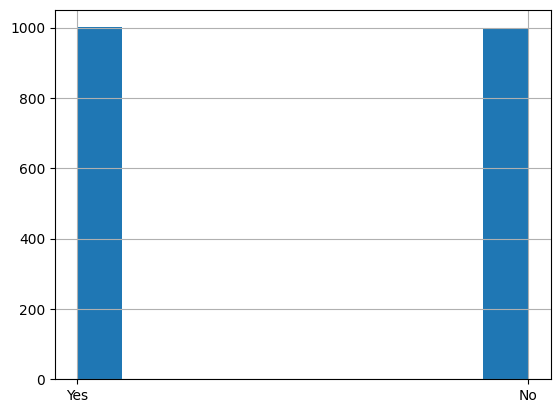

In [6]:
df_test["prediction"].hist()

In [7]:
import pandas as pd
from sklearn.metrics import f1_score

def clean_violates_rule(val):
    if isinstance(val, bool):
        return "Yes" if val else "No"
    if isinstance(val, str):
        val_clean = val.strip().strip('"').strip("'").capitalize()
        if val_clean in ["Yes", "No"]:
            return val_clean
    return "Unknown"  # or np.nan or keep as-is depending on your needs

df_test["violates_rule"] = df_test["violates_rule"].apply(clean_violates_rule)


# Normalize violates_rule to Yes/No
df_test["violates_rule"] = df_test["violates_rule"].map({True: "Yes", False: "No", "Yes": "Yes", "No": "No"})

# Compute F1 score (convert Yes/No to 1/0)
y_true = df_test["violates_rule"].map({"Yes": 1, "No": 0})
y_pred = df_test["prediction"].map({"Yes": 1, "No": 0})

f1 = f1_score(y_true, y_pred)

print("F1-score:", f1)


F1-score: 0.9975012493753124
